In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cuda


In [ ]:
# Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math

from pandas_datareader import data
import yfinance as yf
yf.pdr_override()


ticker_list = ['^GSPC']
name_list = ['S&P500']
start_date = '2001-01-01'
end_date = '2024-01-01'

sp = data.get_data_yahoo(ticker_list, start=start_date, end=end_date).reset_index()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


In [ ]:
df_train = sp[sp['Date'] < '2020-01-01']
df_test = sp[sp['Date'] >= '2020-01-01']

In [ ]:
df_train.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


In [ ]:
x_train = df_train.drop(['Date'], axis =1)
x_test = df_test.drop(['Date'], axis =1)

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
y_train = df_train['Adj Close'].values
y_test = df_test['Adj Close'].values

In [ ]:
# Sequence Data Preparation
SEQUENCE_SIZE = 20
D = x_train.shape[1]

def to_sequences(seq_size, input, target, D):
    x = np.zeros((len(input)-seq_size, seq_size, D))
    y = np.zeros((len(target)-seq_size, 1))
    for t in range(len(input)-seq_size):
      x[t, :, :] = input[t:(t+seq_size)]
      y[t] = (target[t+seq_size])

    return torch.from_numpy(x.astype(np.float32)), torch.from_numpy(y.astype(np.float32))

X_train, Y_train = to_sequences(SEQUENCE_SIZE, x_train,y_train, D)
X_test, Y_test = to_sequences(SEQUENCE_SIZE, x_test, y_test, D)

In [ ]:
X_test.shape

torch.Size([986, 20, 6])

In [ ]:
# Setup data loaders for batch
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### LSTM

In [ ]:
# Model definition
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        # Change input_size to match input dim
        self.lstm = nn.LSTM(input_size=D, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/1000, Validation Loss: 5653558.1048
Epoch 2/1000, Validation Loss: 5637412.8306
Epoch 3/1000, Validation Loss: 5690619.8548
Epoch 4/1000, Validation Loss: 5628483.9153
Epoch 5/1000, Validation Loss: 5548252.8831
Epoch 6/1000, Validation Loss: 5565430.6351
Epoch 7/1000, Validation Loss: 5440302.4335
Epoch 8/1000, Validation Loss: 5325934.1089
Epoch 9/1000, Validation Loss: 5042986.3125
Epoch 10/1000, Validation Loss: 4948658.8226
Epoch 11/1000, Validation Loss: 4739428.8891
Epoch 12/1000, Validation Loss: 4591353.8710
Epoch 13/1000, Validation Loss: 4387843.0262
Epoch 14/1000, Validation Loss: 4138396.9022
Epoch 15/1000, Validation Loss: 3831261.2298
Epoch 16/1000, Validation Loss: 3548953.8538
Epoch 17/1000, Validation Loss: 3264748.9209
Epoch 18/1000, Validation Loss: 2996797.3125
Epoch 19/1000, Validation Loss: 2729092.1172
Epoch 20/1000, Validation Loss: 2514783.2616
Epoch 21/1000, Validation Loss: 2330900.9073
Epoch 22/1000, Validation Loss: 2170548.7378
Epoch 23/1000, Vali

In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.flatten().tolist())

rmse = np.sqrt(np.mean(((np.array(predictions).reshape(-1, 1)) - (Y_train.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 20.3014


In [ ]:
plot_df = pd.DataFrame(Y_train).rename(columns={0:'actual'})
plot_df['prediction'] = predictions
plot_df.head(5)

,actual,prediction
0,1366.010010,1372.129028
1,1373.469971,1379.978394
2,1349.469971,1378.482178
3,1354.310059,1363.521118
4,1352.260010,1350.896851


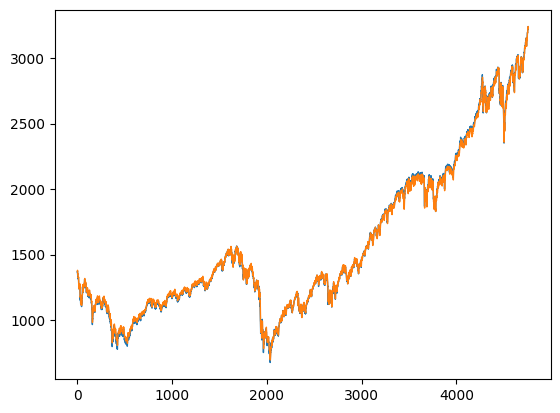

In [ ]:
import matplotlib.pyplot as plt

plt.plot(plot_df['actual'], label='Actual', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)

In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.flatten().tolist())

rmse = np.sqrt(np.mean(((np.array(predictions).reshape(-1, 1)) - (Y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 303.6508


In [ ]:
plot_df = pd.DataFrame(Y_test).rename(columns={0:'actual'})
plot_df['prediction'] = predictions
plot_df.head(5)

,actual,prediction
0,3225.520020,3281.770996
1,3248.919922,3255.600586
2,3297.590088,3258.813232
3,3334.689941,3302.258789
4,3345.780029,3336.990234


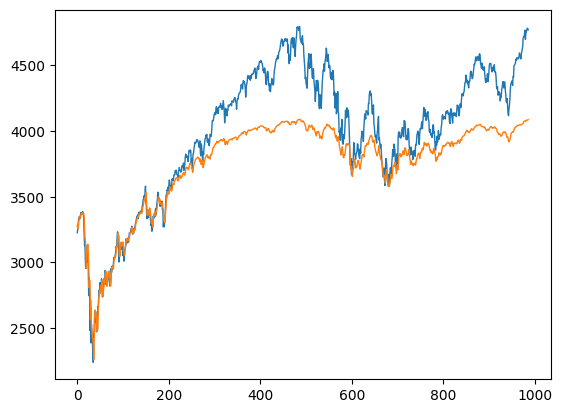

In [ ]:
plt.plot(plot_df['actual'], label='Actual', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)